# Simple Solution SymPy Code Generation

In [1]:
import pandas as pd
import numpy as np
import sympy as sym
sym.init_printing()
from thermoengine import coder
from thermoengine import core

## Simple Solution Properties - Structure of the Equations
There are three terms:
- Terms describing standard state contributions
- Terms describing the configurational entropy of solution
- Terms describing the excess enthalpy of solution  

Assumptions:
- There are $c$ components in the system
- There are as many endmember species, $s$, as there are components
- The configurational entropy is described as a simple $x_i log(x_i)$ sum
- The excess enthalpy is described using an asymmetric regular solution $\left[ {{W_{ij}} + \Delta {W_{ij}}\left( {{X_i} - {X_j}} \right)} \right]{X_i}{X_j}$, where the $W_{ij}$ and $\Delta{W_{ij}}$ are allowed to be first order functions of both $T$ and $P$
- Ternary interaction terms are permittted, i.e. $W_{ijk}$

## Number of solution components
This notebook illustrates a three component solution

In [2]:
c = 3

## Create a simple solution model
... with the specified number of endmember thermodynamic components

In [3]:
model = coder.SimpleSolnModel(nc=c)

## Retrieve primary compositional variables
- $n$ is a vector of mole numbers of each component  
- $n_T$ is the total number of moles in the solution
### and construct a derived mole fraction variable
- $X$ is a vector of mole fractions of components in the system

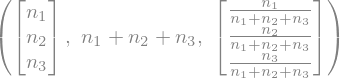

In [4]:
n = model.n
nT = model.nT
X = n/nT
n, nT, X

## Retrieve the temperature, pressure, and standard state chemical potentials
- $T$ is temperature in $K$
- $P$ is pressure in $bars$
- $\mu$ in Joules

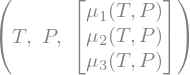

In [5]:
T = model.get_symbol_for_t()
P = model.get_symbol_for_p()
mu = model.mu
T,P,mu

## Define the standard state contribution to solution properties

In [6]:
G_ss = (n.transpose()*mu)[0]
G_ss

## Define configurational entropy and configurational Gibbs free energy

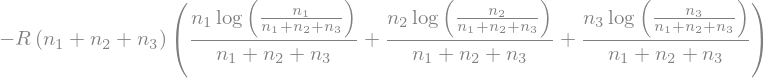

In [7]:
S_config,R = sym.symbols('S_config R')
S_config = 0
for i in range(0,c):
    S_config += X[i]*sym.log(X[i])
S_config *= -R*nT
S_config

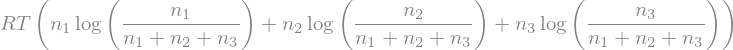

In [8]:
G_config = sym.simplify(-T*S_config)
G_config

## Parameterize the excess free energy
- Symmetric terms: $W_{ij} = Wh_{ij} - T Ws_{ij} + P Wv_{ij}$, where $Wh_{ij}$ is the excess enthalpy along the $i$-$j$ binary, $Ws_{ij}$ is the excess entropy, and $Wv_{ij}$ is the excess volume
- Asymetric terms: $\Delta W_{ij} = \Delta Wh_{ij} - T \Delta Ws_{ij} + P \Delta Wv_{ij}$
- Convention: $\left[ {{W_{ij}} + \Delta {W_{ij}}\left( {{X_i} - {X_j}} \right)} \right]{X_i}{X_j} = \left( {{W_{ij}} + \Delta {W_{ij}}} \right)X_i^2{X_j} + \left( {{W_{ij}} - \Delta {W_{ij}}} \right){X_i}X_j^2 = {W_{iij}}X_i^2{X_j} + {W_{ijj}}{X_i}X_j^2$  
- Strictly ternary terms: $W_{ijk}X_iX_jX_k$, where $i {\ne} j {\ne} k$

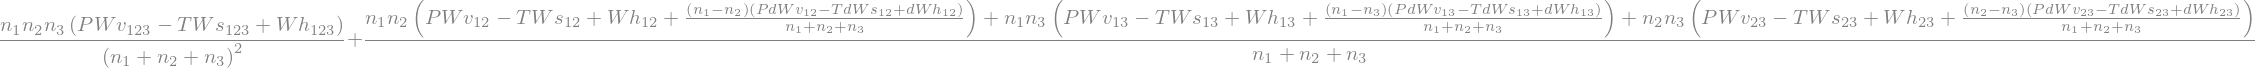

In [9]:
module = 'asymm_regular'
params = []
units = []
symparam = ()
G_excess = sym.symbols('G_excess')
G_excess = 0
for i in range(1,c):
    for j in range(i+1,c+1):
        param = 'Wh' + str(i) + str(j); params.append(param); units.append('J/m')
        h_term = sym.symbols(param); symparam += (h_term,)
        param = 'Ws' + str(i) + str(j); params.append(param); units.append('J/K-m')
        s_term = sym.symbols(param); symparam += (s_term,)
        param = 'Wv' + str(i) + str(j); params.append(param); units.append('J/bar-m')
        v_term = sym.symbols(param); symparam += (v_term,)
        param = 'dWh' + str(i) + str(j); params.append(param); units.append('J/m')
        dh_term = sym.symbols(param); symparam += (dh_term,)
        param = 'dWs' + str(i) + str(j); params.append(param); units.append('J/K-m')
        ds_term = sym.symbols(param); symparam += (ds_term,)
        param = 'dWv' + str(i) + str(j); params.append(param); units.append('J/bar-m')
        dv_term = sym.symbols(param); symparam += (dv_term,)
        w_term = h_term - T*s_term + P*v_term
        dw_term = dh_term - T*ds_term + P*dv_term
        G_excess += (w_term + dw_term*(n[i-1]-n[j-1])/nT)*n[i-1]*n[j-1]
G_excess /= nT
for i in range(1,c-1):
    for j in range(i+1,c):
        for k in range(j+1,c+1):
            param = 'Wh' + str(i) + str(j) + str(k); params.append(param); units.append('J/m')
            h_term = sym.symbols(param); symparam += (h_term,)
            param = 'Ws' + str(i) + str(j) + str(k); params.append(param); units.append('J/K-m')
            s_term = sym.symbols(param); symparam += (s_term,)
            param = 'Wv' + str(i) + str(j) + str(k); params.append(param); units.append('J/bar-m')
            v_term = sym.symbols(param); symparam += (v_term,)
            G_excess += (h_term - T*s_term + P*v_term)*n[i-1]*n[j-1]*n[k-1]/nT/nT
G_excess

In [10]:
print(params)
print(units)

['Wh12', 'Ws12', 'Wv12', 'dWh12', 'dWs12', 'dWv12', 'Wh13', 'Ws13', 'Wv13', 'dWh13', 'dWs13', 'dWv13', 'Wh23', 'Ws23', 'Wv23', 'dWh23', 'dWs23', 'dWv23', 'Wh123', 'Ws123', 'Wv123']
['J/m', 'J/K-m', 'J/bar-m', 'J/m', 'J/K-m', 'J/bar-m', 'J/m', 'J/K-m', 'J/bar-m', 'J/m', 'J/K-m', 'J/bar-m', 'J/m', 'J/K-m', 'J/bar-m', 'J/m', 'J/K-m', 'J/bar-m', 'J/m', 'J/K-m', 'J/bar-m']


## Define the Gibbs free energy of solution

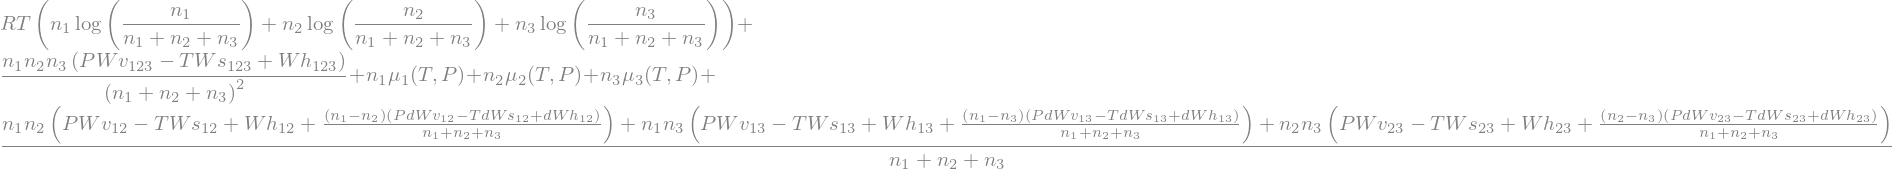

In [11]:
G = G_ss + G_config + G_excess
G

## Add the Gibbs free energy of solution to the model

In [12]:
model.add_expression_to_model(G, list(zip(params, units, symparam)))

... give the model a unqiue name

In [13]:
model.module = "Simple_Solution"

... assign a formula string for code generation  
... assign a conversion string to map element concentrations to moles of end members

In [14]:
model.formula_string = 'Ca[Ca]Na[Na]K[K]Al[Al]Si[Si]O8'
model.conversion_string = ['[0]=[Na]', '[1]=[Ca]', '[2]=[K]']
model.test_string = ['[0] > 0.0', '[1] > 0.0', '[2] > 0.0']

# Define Parameters of a Feldspar Solution
Components
1. albite, ${\rm{NaAlSi_3O_8}}$
2. anorthite, ${\rm{CaAl_2Si_2O_8}}$
3. sanidine, ${\rm{KAlSi_3O_8}}$

Original calibration from the Elkins-Grove paper using their notation:
```
whabor   = 18810.0;  /* joules     */
wsabor   = 10.3;     /* joules/K   */
wvabor   = 0.4602;   /* joules/bar */
whorab   = 27320.0;  /* joules     */
wsorab   = 10.3;     /* joules/K   */
wvorab   = 0.3264;   /* joules/bar */
whaban   = 7924.0;   /* joules     */
whanab   = 0.0;      /* joules     */
whoran   = 40317.0;  /* joules     */
whanor   = 38974.0;  /* joules     */
wvanor   = -0.1037;  /* joules/bar */
whabanor = 12545.0;  /* joules     */
wvabanor = -1.095;   /* joules/bar */
```

Note that in the notation derveloped in this paper, $\left[ {{W_{ij}} + \Delta {W_{ij}}\left( {{X_i} - {X_j}} \right)} \right]{X_i}{X_j}$, is related to the convention used in the original paper: ${{\tilde W}_{13}}{X_1}{X_3}\left( {{X_3} + \frac{{{X_2}}}{2}} \right) + {{\tilde W}_{31}}{X_1}{X_3}\left( {{X_1} + \frac{{{X_2}}}{2}} \right)$:   
- ${W_{13}} = {{\tilde W}_{13}} + {{\tilde W}_{31}}$
- $d{W_{13}} = {{\tilde W}_{31}} - {{\tilde W}_{13}}$

In [15]:
print (params)
whabor   = 18810.0
wsabor   = 10.3
wvabor   = 0.4602
whorab   = 27320.0
wsorab   = 10.3
wvorab   = 0.3264
whaban   = 7924.0
whanab   = 0.0
whoran   = 40317.0
whanor   = 38974.0
wvanor   = -0.1037
wvoran   = 0.0 
whabanor = 12545.0
wvabanor = -1.095
paramValues = { 'Wh12':whaban+whanab,  'Ws12':0.0,            'Wv12':0.0, \
                'Wh13':whabor+whorab,  'Ws13':wsabor+wsorab,  'Wv13':wvabor+wvorab, \
                'Wh23':whanor+whoran,  'Ws23':0.0,            'Wv23':wvanor+wvoran, \
                'dWh12':whanab-whaban, 'dWs12':0.0,           'dWv12':0.0, \
                'dWh13':whorab-whabor, 'dWs13':wsorab-wsabor, 'dWv13':wvorab-wvabor, \
                'dWh23':whoran-whanor, 'dWs23':0.0,           'dWv23':wvoran-wvanor,
                'Wh123':whabanor, 'Ws123':0.0, 'Wv123':wvabanor, 'T_r':298.15, 'P_r':1.0}
print (paramValues)

['Wh12', 'Ws12', 'Wv12', 'dWh12', 'dWs12', 'dWv12', 'Wh13', 'Ws13', 'Wv13', 'dWh13', 'dWs13', 'dWv13', 'Wh23', 'Ws23', 'Wv23', 'dWh23', 'dWs23', 'dWv23', 'Wh123', 'Ws123', 'Wv123']
{'Wh12': 7924.0, 'Ws12': 0.0, 'Wv12': 0.0, 'Wh13': 46130.0, 'Ws13': 20.6, 'Wv13': 0.7866, 'Wh23': 79291.0, 'Ws23': 0.0, 'Wv23': -0.1037, 'dWh12': -7924.0, 'dWs12': 0.0, 'dWv12': 0.0, 'dWh13': 8510.0, 'dWs13': 0.0, 'dWv13': -0.13379999999999997, 'dWh23': 1343.0, 'dWs23': 0.0, 'dWv23': 0.1037, 'Wh123': 12545.0, 'Ws123': 0.0, 'Wv123': -1.095, 'T_r': 298.15, 'P_r': 1.0}


Generate both fast computation and calibibration code for the feldspar solution

# Use code printers to construct "C" package code

In [16]:
model_working_dir = "working"
!mkdir -p {model_working_dir}
%cd {model_working_dir}

/Users/simonmatthews/Dropbox/projects/enki-speciation/coder_expts/working


## Choose model type and create model
model_type is "fast" or "calib"

In [17]:
model_type = "calib"

In [18]:
model.create_code_module(phase="Feldspar", params=paramValues, 
                         endmembers=['High_Albite_berman', 'Anorthite_berman', 'Potassium_Feldspar_berman'], 
                         prefix="cy", module_type=model_type, silent=False)

Creating generic fast model code file string
Writing include file to working directory ...
Creating (once only) generic model calib codetemplate include file string
Creating (once only) generic model calib codetemplate code file string
Creating generic calib model code file string
Writing include file to working directory ...
Creating code blocks for standard state properties.
Creating calib code and include files ...
Writing include file to working directory ...
Writing code file to working directory ...
... done
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  Simple_Solution


True

Update cython wrappers generated in Example #1 notebook to substitute the berman module name with that of teh solution

In [19]:
with open('endmembers.pyx', 'r') as f:
    contents = f.read()
contents = contents.replace('def cy_High_Albite_berman_', 'def cy_High_Albite_Simple_Solution_')
contents = contents.replace('def cy_Anorthite_berman_', 'def cy_Anorthite_Simple_Solution_')
contents = contents.replace('def cy_Potassium_Feldspar_berman_', 'def cy_Potassium_Feldspar_Simple_Solution_')
with open('endmembers.pyx', 'w') as f:
    f.write(contents)

FileNotFoundError: [Errno 2] No such file or directory: 'endmembers.pyx'

Concatenate the ./working/endmembers.pyx file, which was generated by running the Example #1 notebook, to the end of the Simple_Solution.pyx file.  This will allow cython wrappers that expose endmember properties to be visible in the resulting module.

In [ ]:
%cat endmembers.pyx >> Simple_Solution.pyx

## Load the module

In [ ]:
import Simple_Solution
%cd ..

## Test and time the generated functions for Feldspar (T in K, P in bars)

In [ ]:
t = 2000.00
p = 1.0
n = np.array([1.1, 1.2, 1.3])

## Available in both "Fast" and "Calib" code versions 
Execute the "fast" or "calibration" code metadata retrieval functions:

In [ ]:
try:
    print(Simple_Solution.cy_Feldspar_Simple_Solution_identifier())
    print(Simple_Solution.cy_Feldspar_Simple_Solution_name())
    print(Simple_Solution.cy_Feldspar_Simple_Solution_formula(t,p,n))
except AttributeError:
    pass
try:
    print(Simple_Solution.cy_Feldspar_Simple_Solution_calib_identifier())
    print(Simple_Solution.cy_Feldspar_Simple_Solution_calib_name())
    print(Simple_Solution.cy_Feldspar_Simple_Solution_calib_formula(t,p,n))
except AttributeError:
    pass

Test intrinsic element conversion routine ...

In [ ]:
try:
    e = np.zeros(106)
    sum = np.sum(n)
    for index in range(0,c):
        end = Simple_Solution.cy_Feldspar_Simple_Solution_endmember_elements(index)
        for i in range(0,106):
            e[i] += end[i]*n[index]/sum
    nConv = Simple_Solution.cy_Feldspar_Simple_Solution_conv_elm_to_moles(e)
    for i in range(0,c):
        print ('X[{0:d}] input {1:13.6e}, calc {2:13.6e}, diff {3:13.6e}'.format(
        i, n[i]/sum, nConv[i], nConv[i]-n[i]/sum))
    if not Simple_Solution.cy_Feldspar_Simple_Solution_test_moles(nConv):
        print ('Output of intrinsic composition calculation fails tests for permissible values.')
except AttributeError:
    pass
try:
    e = np.zeros(106)
    sum = np.sum(n)
    for index in range(0,c):
        end = Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_elements(index)
        for i in range(0,106):
            e[i] += end[i]*n[index]/sum
    nConv = Simple_Solution.cy_Feldspar_Simple_Solution_calib_conv_elm_to_moles(e)
    for i in range(0,c):
        print ('X[{0:d}] input {1:13.6e}, calc {2:13.6e}, diff {3:13.6e}'.format(
        i, n[i]/sum, nConv[i], nConv[i]-n[i]/sum))
    if not Simple_Solution.cy_Feldspar_Simple_Solution_calib_test_moles(nConv):
        print ('Output of intrinsic composition calculation fails tests for permissible values.')
except AttributeError:
    pass

Test various conversion routines ...

In [ ]:
try:
    print (Simple_Solution.cy_Feldspar_Simple_Solution_calib_conv_moles_to_tot_moles(n))
    print (Simple_Solution.cy_Feldspar_Simple_Solution_calib_conv_moles_to_mole_frac(n))
    e = Simple_Solution.cy_Feldspar_Simple_Solution_calib_conv_moles_to_elm(n)
    print (e)
    print (Simple_Solution.cy_Feldspar_Simple_Solution_calib_conv_elm_to_moles(e))
    print (Simple_Solution.cy_Feldspar_Simple_Solution_calib_conv_elm_to_tot_moles(e))
    print (Simple_Solution.cy_Feldspar_Simple_Solution_calib_conv_elm_to_tot_grams(e))
except AttributeError:
    pass
try:
    print (Simple_Solution.cy_Feldspar_Simple_Solution_conv_moles_to_tot_moles(n))
    print (Simple_Solution.cy_Feldspar_Simple_Solution_conv_moles_to_mole_frac(n))
    e = Simple_Solution.cy_Feldspar_Simple_Solution_conv_moles_to_elm(n)
    print (e)
    print (Simple_Solution.cy_Feldspar_Simple_Solution_conv_elm_to_moles(e))
    print (Simple_Solution.cy_Feldspar_Simple_Solution_conv_elm_to_tot_moles(e))
    print (Simple_Solution.cy_Feldspar_Simple_Solution_conv_elm_to_tot_grams(e))
except AttributeError:
    pass

### Execute the standard thermodynamic property retrieval functions:

In [ ]:
fmt = "{0:<10.10s} {1:13.6e} {2:<10.10s}"
try:
    print(fmt.format('G', Simple_Solution.cy_Feldspar_Simple_Solution_g(t,p,n), 'J'))
    print(fmt.format('dGdT', Simple_Solution.cy_Feldspar_Simple_Solution_dgdt(t,p,n), 'J/K'))
    print(fmt.format('dGdP', Simple_Solution.cy_Feldspar_Simple_Solution_dgdp(t,p,n), 'J/bar'))
    print(fmt.format('d2GdT2', Simple_Solution.cy_Feldspar_Simple_Solution_d2gdt2(t,p,n), 'J/K^2'))
    print(fmt.format('d2GdTdP', Simple_Solution.cy_Feldspar_Simple_Solution_d2gdtdp(t,p,n), 'J/K-bar'))
    print(fmt.format('d2GdP2', Simple_Solution.cy_Feldspar_Simple_Solution_d2gdp2(t,p,n), 'J/bar^2'))
    print(fmt.format('d3GdT3', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdt3(t,p,n), 'J/K^3'))
    print(fmt.format('d3GdT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdt2dp(t,p,n), 'J/K^2-bar'))
    print(fmt.format('d3GdTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdtdp2(t,p,n), 'J/K-bar^2'))
    print(fmt.format('d3GdP3', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdp3(t,p,n), 'J/bar^3'))
    print(fmt.format('S', Simple_Solution.cy_Feldspar_Simple_Solution_s(t,p,n), 'J/K'))
    print(fmt.format('V', Simple_Solution.cy_Feldspar_Simple_Solution_v(t,p,n), 'J/bar'))
    print(fmt.format('Cv', Simple_Solution.cy_Feldspar_Simple_Solution_cv(t,p,n), 'J/K'))
    print(fmt.format('Cp', Simple_Solution.cy_Feldspar_Simple_Solution_cp(t,p,n), 'J/K'))
    print(fmt.format('dCpdT', Simple_Solution.cy_Feldspar_Simple_Solution_dcpdt(t,p,n), 'J/K^2'))
    print(fmt.format('alpha', Simple_Solution.cy_Feldspar_Simple_Solution_alpha(t,p,n), '1/K'))
    print(fmt.format('beta', Simple_Solution.cy_Feldspar_Simple_Solution_beta(t,p,n), '1/bar'))
    print(fmt.format('K', Simple_Solution.cy_Feldspar_Simple_Solution_K(t,p,n), 'bar'))
    print(fmt.format('Kp', Simple_Solution.cy_Feldspar_Simple_Solution_Kp(t,p,n), ''))
except AttributeError:
    pass
try:
    print(fmt.format('G', Simple_Solution.cy_Feldspar_Simple_Solution_calib_g(t,p,n), 'J'))
    print(fmt.format('dGdT', Simple_Solution.cy_Feldspar_Simple_Solution_calib_dgdt(t,p,n), 'J/K'))
    print(fmt.format('dGdP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_dgdp(t,p,n), 'J/bar'))
    print(fmt.format('d2GdT2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d2gdt2(t,p,n), 'J/K^2'))
    print(fmt.format('d2GdTdP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d2gdtdp(t,p,n), 'J/K-bar'))
    print(fmt.format('d2GdP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d2gdp2(t,p,n), 'J/bar^2'))
    print(fmt.format('d3GdT3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdt3(t,p,n), 'J/K^3'))
    print(fmt.format('d3GdT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdt2dp(t,p,n), 'J/K^2-bar'))
    print(fmt.format('d3GdTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdtdp2(t,p,n), 'J/K-bar^2'))
    print(fmt.format('d3GdP3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdp3(t,p,n), 'J/bar^3'))
    print(fmt.format('S', Simple_Solution.cy_Feldspar_Simple_Solution_calib_s(t,p,n), 'J/K'))
    print(fmt.format('V', Simple_Solution.cy_Feldspar_Simple_Solution_calib_v(t,p,n), 'J/bar'))
    print(fmt.format('Cv', Simple_Solution.cy_Feldspar_Simple_Solution_calib_cv(t,p,n), 'J/K'))
    print(fmt.format('Cp', Simple_Solution.cy_Feldspar_Simple_Solution_calib_cp(t,p,n), 'J/K'))
    print(fmt.format('dCpdT', Simple_Solution.cy_Feldspar_Simple_Solution_calib_dcpdt(t,p,n), 'J/K^2'))
    print(fmt.format('alpha', Simple_Solution.cy_Feldspar_Simple_Solution_calib_alpha(t,p,n), '1/K'))
    print(fmt.format('beta', Simple_Solution.cy_Feldspar_Simple_Solution_calib_beta(t,p,n), '1/bar'))
    print(fmt.format('K', Simple_Solution.cy_Feldspar_Simple_Solution_calib_K(t,p,n), 'bar'))
    print(fmt.format('Kp', Simple_Solution.cy_Feldspar_Simple_Solution_calib_Kp(t,p,n), ''))
except AttributeError:
    pass

### Execute functions that access endmember properties:

In [ ]:
fmt = "{0:<10.10s} {1:13.6e} {2:<15.15s}"
try:
    print ("number of components", Simple_Solution.cy_Feldspar_Simple_Solution_endmember_number())
    for index in range(0, c):
        print ("{0:<20.20s}".format(Simple_Solution.cy_Feldspar_Simple_Solution_endmember_name(index)), end=' ')
        print ("{0:<20.20s}".format(Simple_Solution.cy_Feldspar_Simple_Solution_endmember_formula(index)))
        print ("mw: {0:10.2f}".format(Simple_Solution.cy_Feldspar_Simple_Solution_endmember_mw(index)))
        print (fmt.format('mu0', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_mu0(index,t,p), 'J/mol'))
        print (fmt.format('dmu0dT', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_dmu0dT(index,t,p), 'J/K-mol'))
        print (fmt.format('dmu0dP', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_dmu0dP(index,t,p), 'J/bar-mol'))
        print (fmt.format('d2mu0dT2', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_d2mu0dT2(index,t,p), 'J/K^2-mol'))
        print (fmt.format('d2mu0dTdP', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_d2mu0dTdP(index,t,p), 'J/K-bar-mol'))
        print (fmt.format('d2mu0dP2', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_d2mu0dP2(index,t,p), 'J/bar^2-mol'))
        print (fmt.format('d3mu0dT3', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_d3mu0dT3(index,t,p), 'J/K^3-mol'))
        print (fmt.format('d3mu0dT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_d3mu0dT2dP(index,t,p), 'J/K^2-bar-mol'))
        print (fmt.format('d3mu0dTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_d3mu0dTdP2(index,t,p), 'J/K-bar^2-mol'))
        print (fmt.format('d3mu0dP3', Simple_Solution.cy_Feldspar_Simple_Solution_endmember_d3mu0dP3(index,t,p), 'J/bar^3-mol'))
        print ("Element array:")
        print (Simple_Solution.cy_Feldspar_Simple_Solution_endmember_elements(index))
        print ()
except AttributeError:
    pass
try:
    print ("number of components", Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_number())
    for index in range(0, c):
        print ("{0:<20.20s}".format(Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_name(index)), end=' ')
        print ("{0:<20.20s}".format(Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_formula(index)), end=' ')
        print ("mw: {0:10.2f}".format(Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_mw(index)))
        print (fmt.format('mu0', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_mu0(index,t,p), 'J/mol'))
        print (fmt.format('dmu0dT', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_dmu0dT(index,t,p), 'J/K-mol'))
        print (fmt.format('dmu0dP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_dmu0dP(index,t,p), 'J/bar-mol'))
        print (fmt.format('d2mu0dT2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_d2mu0dT2(index,t,p), 'J/K^2-mol'))
        print (fmt.format('d2mu0dTdP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_d2mu0dTdP(index,t,p), 'J/K-bar-mol'))
        print (fmt.format('d2mu0dP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_d2mu0dP2(index,t,p), 'J/bar^2-mol'))
        print (fmt.format('d3mu0dT3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_d3mu0dT3(index,t,p), 'J/K^3-mol'))
        print (fmt.format('d3mu0dT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_d3mu0dT2dP(index,t,p), 'J/K^2-bar-mol'))
        print (fmt.format('d3mu0dTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_d3mu0dTdP2(index,t,p), 'J/K-bar^2-mol'))
        print (fmt.format('d3mu0dP3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_d3mu0dP3(index,t,p), 'J/bar^3-mol'))
        print ("Element array:")
        print (Simple_Solution.cy_Feldspar_Simple_Solution_calib_endmember_elements(index))
        print ()
except AttributeError:
    pass

### Execute functions that access species properties:

In [ ]:
fmt = "{0:<10.10s} {1:13.6e} {2:<15.15s}"
try:
    print ("number of species", Simple_Solution.cy_Feldspar_Simple_Solution_species_number())
    for index in range(0, c):
        print ("{0:<20.20s}".format(Simple_Solution.cy_Feldspar_Simple_Solution_species_name(index)), end=' ')
        print ("{0:<20.20s}".format(Simple_Solution.cy_Feldspar_Simple_Solution_species_formula(index)))
        print ("mw: {0:10.2f}".format(Simple_Solution.cy_Feldspar_Simple_Solution_species_mw(index)))
        print ("Element array:")
        print (Simple_Solution.cy_Feldspar_Simple_Solution_species_elements(index))
        print ()
except AttributeError:
    pass
try:
    print ("number of species", Simple_Solution.cy_Feldspar_Simple_Solution_calib_species_number())
    for index in range(0, c):
        print ("{0:<20.20s}".format(Simple_Solution.cy_Feldspar_Simple_Solution_calib_species_name(index)), end=' ')
        print ("{0:<20.20s}".format(Simple_Solution.cy_Feldspar_Simple_Solution_calib_species_formula(index)), end=' ')
        print ("mw: {0:10.2f}".format(Simple_Solution.cy_Feldspar_Simple_Solution_calib_species_mw(index)))
        print ("Element array:")
        print (Simple_Solution.cy_Feldspar_Simple_Solution_calib_species_elements(index))
        print ()
except AttributeError:
    pass

### Execute functions for molar derivatives
#### First derivative vectors:

In [ ]:
def printResult(name, result, units):
    print ("{0:<10.10s}".format(name), end=' ')
    [print ("{0:13.6e}".format(x), end=' ') for x in result]
    print ("{0:<10.10s}".format(units))
def printLabels(n):
    print ("{0:<18.18s}".format(''), end=' ')
    [print ("[{0:3d}]{1:<8.8s}".format(idx, ''), end=' ') for idx in range(len(n))]
    print ()
printLabels(n)
try:
    printResult('dGdn', Simple_Solution.cy_Feldspar_Simple_Solution_dgdn(t,p,n), 'J/m')
    printResult('d2GdndT', Simple_Solution.cy_Feldspar_Simple_Solution_d2gdndt(t,p,n), 'J/K-m')
    printResult('d2GdndP', Simple_Solution.cy_Feldspar_Simple_Solution_d2gdndp(t,p,n), 'J/bar-m')
    printResult('d3GdndT2', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdndt2(t,p,n), 'J/K^2-m')
    printResult('d3GdndTdP', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdndtdp(t,p,n), 'J/K-bar-m')
    printResult('d3GdndP2', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdndp2(t,p,n), 'J/bar^2-m')
    printResult('d4GdndT3', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdndt3(t,p,n), 'J/K^3-m')
    printResult('d4GdndT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdndt2dp(t,p,n), 'J/K^2-bar-m')
    printResult('d4GdndTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdndtdp2(t,p,n), 'J/K-bar^2-m')
    printResult('d4GdndP3', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdndp3(t,p,n), 'J/bar^3-m')
except AttributeError:
    pass
try:
    printResult('dGdn', Simple_Solution.cy_Feldspar_Simple_Solution_calib_dgdn(t,p,n), 'J/m')
    printResult('d2GdndT', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d2gdndt(t,p,n), 'J/K-m')
    printResult('d2GdndP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d2gdndp(t,p,n), 'J/bar-m')
    printResult('d3GdndT2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdndt2(t,p,n), 'J/K^2-m')
    printResult('d3GdndTdP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdndtdp(t,p,n), 'J/K-bar-m')
    printResult('d3GdndP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdndp2(t,p,n), 'J/bar^2-m')
    printResult('d4GdndT3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdndt3(t,p,n), 'J/K^3-m')
    printResult('d4GdndT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdndt2dp(t,p,n), 'J/K^2-bar-m')
    printResult('d4GdndTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdndtdp2(t,p,n), 'J/K-bar^2-m')
    printResult('d4GdndP3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdndp3(t,p,n), 'J/bar^3-m')
except AttributeError:
    pass    

#### The Hessian matrix (molar second derivative matrix) is stored as a compact linear array
A function is provided to map matrix indices to compact storage 1-D array indices

In [ ]:
for i in range(1,c+1):
    print ("[ ", end=' ')
    for j in range (1,c+1):
        print ((i,j), end=' ')
    print (']     [', end=' ')
    for j in range (1,c+1):
        print (model.symmetric_index_from_2d_array(elm=(i,j)), end=' ')
    print (']')

In [ ]:
def printResult(name, result, units):
    print ("{0:<10.10s}".format(name), end=' ')
    [print ("{0:13.6e}".format(x), end=' ') for x in result]
    print ("{0:<10.10s}".format(units))
def printLabels(n):
    print ("{0:<18.18s}".format(''), end=' ')
    maxIdx = int(len(n)*(len(n)-1)/2 + len(n))
    [print ("[{0:3d}]{1:<8.8s}".format(idx, ''), end=' ') for idx in range(maxIdx)]
    print ()
printLabels(n)
try:
    printResult('d2Gdn2', Simple_Solution.cy_Feldspar_Simple_Solution_d2gdn2(t,p,n), 'J/m^2')
    printResult('d3Gdn2dT', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdn2dt(t,p,n), 'J/K-m^2')
    printResult('d3Gdn2dP', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdn2dp(t,p,n), 'J/bar-m^2')
    printResult('d4Gdn2dT2', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdn2dt2(t,p,n), 'J/K^2-m^2')
    printResult('d4Gdn2dTdP', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdn2dtdp(t,p,n), 'J/K-bar-m^2')
    printResult('d4Gdn2dP2', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdn2dp2(t,p,n), 'J/bar^2-m^2')
    printResult('d5Gdn2dT3', Simple_Solution.cy_Feldspar_Simple_Solution_d5gdn2dt3(t,p,n), 'J/K^3-m^2')
    printResult('d5Gdn2dT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_d5gdn2dt2dp(t,p,n), 'J/K^2-bar-m^2')
    printResult('d5Gdn2dTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_d5gdn2dtdp2(t,p,n), 'J/K-bar^2-m^2')
    printResult('d5Gdn2dP3', Simple_Solution.cy_Feldspar_Simple_Solution_d5gdn2dp3(t,p,n), 'J/bar^3-m^2')
except AttributeError:
    pass
try:
    printResult('d2Gdn2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d2gdn2(t,p,n), 'J/m^2')
    printResult('d3Gdn2dT', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdn2dt(t,p,n), 'J/K-m^2')
    printResult('d3Gdn2dP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdn2dp(t,p,n), 'J/bar-m^2')
    printResult('d4Gdn2dT2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdn2dt2(t,p,n), 'J/K^2-m^2')
    printResult('d4Gdn2dTdP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdn2dtdp(t,p,n), 'J/K-bar-m^2')
    printResult('d4Gdn2dP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdn2dp2(t,p,n), 'J/bar^2-m^2')
    printResult('d5Gdn2dT3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d5gdn2dt3(t,p,n), 'J/K^3-m^2')
    printResult('d5Gdn2dT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d5gdn2dt2dp(t,p,n), 'J/K^2-bar-m^2')
    printResult('d5Gdn2dTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d5gdn2dtdp2(t,p,n), 'J/K-bar^2-m^2')
    printResult('d5Gdn2dP3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d5gdn2dp3(t,p,n), 'J/bar^3-m^2')
except AttributeError:
    pass

#### The 3-D Tensor (molar third derivative tensor) is stored as a compact linear array
A function is provided to map matrix indices to compact storage 1-D array indices:  
If $n_c$ represents the number of components in the solution, and  
if $n_d$ represents the dimensionality of molar derivative (in this case 3), then  
the number of numerically ordered permutations of $n_c$ molar derivatives taken $n_d$ at a time is:

In [ ]:
n_c,n_d = sym.symbols('n_c n_d')
q = sym.factorial(n_c+n_d-1)/sym.factorial(n_d)/sym.factorial(n_c-1)
q

Substituting $n_d$ equal to 3 and simplifying gives:

In [ ]:
q = sym.simplify(q.subs(n_d,3))
q

and, for the number of components in this solution, there will be the following number of unique terms in the third derivative tensor:

In [ ]:
q.subs(n_c,c)

A function is provided to map matrix indices to compact storage 1-D array indices

In [ ]:
for i in range(1,c+1):
    for j in range (1,c+1):
        print ("[", end=' ')
        for k in range (1,c+1):
            print ("{0:1d}{1:1d}{2:1d}".format(i,j,k), end=' ')
        print ('] ', end=' ')
    print ('  ->  ', end=' ')
    for j in range (1,c+1):
        print ("[", end=' ')
        for k in range (1,c+1):
            print (model.symmetric_index_from_3d_array(elm=(i,j,k)), end=' ')
        print ('] ', end=' ')
    print ('')

In [ ]:
def printResult(name, result, units):
    print ("{0:<10.10s}".format(name), end=' ')
    [print ("{0:10.3e}".format(x), end=' ') for x in result]
    print ("{0:<14.14s}".format(units))
def printLabels(n):
    print ("{0:<15.15s}".format(''), end=' ')
    maxIdx = int(len(n)*(len(n)+1)*(len(n)+2)/6)
    [print ("[{0:3d}]{1:<5.5s}".format(idx, ''), end=' ') for idx in range(maxIdx)]
    print ()
printLabels(n)
try:
    printResult('d3Gdn3', Simple_Solution.cy_Feldspar_Simple_Solution_d3gdn3(t,p,n), 'J/m^3')
    printResult('d4Gdn3dT', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdn3dt(t,p,n), 'J/K-m^3')
    printResult('d4Gdn3dP', Simple_Solution.cy_Feldspar_Simple_Solution_d4gdn3dp(t,p,n), 'J/bar-m^3')
    printResult('d5Gdn3dT2', Simple_Solution.cy_Feldspar_Simple_Solution_d5gdn3dt2(t,p,n), 'J/K^2-m^3')
    printResult('d5Gdn3dTdP', Simple_Solution.cy_Feldspar_Simple_Solution_d5gdn3dtdp(t,p,n), 'J/K-bar-m^3')
    printResult('d5Gdn3dP2', Simple_Solution.cy_Feldspar_Simple_Solution_d5gdn3dp2(t,p,n), 'J/bar^2-m^3')
    printResult('d6Gdn3dT3', Simple_Solution.cy_Feldspar_Simple_Solution_d6gdn3dt3(t,p,n), 'J/K^3-m^3')
    printResult('d6Gdn3dT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_d6gdn3dt2dp(t,p,n), 'J/K^2-bar-m^3')
    printResult('d6Gdn3dTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_d6gdn3dtdp2(t,p,n), 'J/K-bar^2-m^3')
    printResult('d6Gdn3dP3', Simple_Solution.cy_Feldspar_Simple_Solution_d6gdn3dp3(t,p,n), 'J/bar^3-m^3')
except AttributeError:
    pass
try:
    printResult('d3Gdn3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d3gdn3(t,p,n), 'J/m^3')
    printResult('d4Gdn3dT', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdn3dt(t,p,n), 'J/K-m^3')
    printResult('d4Gdn3dP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d4gdn3dp(t,p,n), 'J/bar-m^3')
    printResult('d5Gdn3dT2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d5gdn3dt2(t,p,n), 'J/K^2-m^3')
    printResult('d5Gdn3dTdP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d5gdn3dtdp(t,p,n), 'J/K-bar-m^3')
    printResult('d5Gdn3dP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d5gdn3dp2(t,p,n), 'J/bar^2-m^3')
    printResult('d6Gdn3dT3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d6gdn3dt3(t,p,n), 'J/K^3-m^3')
    printResult('d6Gdn3dT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d6gdn3dt2dp(t,p,n), 'J/K^2-bar-m^3')
    printResult('d6Gdn3dTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d6gdn3dtdp2(t,p,n), 'J/K-bar^2-m^3')
    printResult('d6Gdn3dP3', Simple_Solution.cy_Feldspar_Simple_Solution_calib_d6gdn3dp3(t,p,n), 'J/bar^3-m^3')
except AttributeError:
    pass

## Test and time the generated functions for Feldspar

Time the code

In [ ]:
try:
    %timeit Simple_Solution.cy_Feldspar_Simple_Solution_g(t, p, n)
except AttributeError:
    pass
try:
    %timeit Simple_Solution.cy_Feldspar_Simple_Solution_calib_g(t, p, n) 
except AttributeError:
    pass

Time the Rubicon wrapped Objective-C code

In [ ]:
from thermoengine import model as stdmodel
modelDB = stdmodel.Database()
FeldsparHC = modelDB.get_phase('Fsp')

In [ ]:
%timeit FeldsparHC.gibbs_energy(t,p,mol=n) 

## Methods available only in the "Calib" versions of generated code
### Execute the parameter value/metadata functions.  
These functions are only defined for the "calibration" model code implementation:

In [ ]:
nparam = 0

In [ ]:
try:
    nparam = Simple_Solution.cy_Feldspar_Simple_Solution_get_param_number()
    names = Simple_Solution.cy_Feldspar_Simple_Solution_get_param_names()
    units = Simple_Solution.cy_Feldspar_Simple_Solution_get_param_units()
    values = Simple_Solution.cy_Feldspar_Simple_Solution_get_param_values()
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,nparam):
        print(fmt.format(names[i], values[i], Simple_Solution.cy_Feldspar_Simple_Solution_get_param_value(i), units[i]))
except AttributeError:
    pass

### Functions that allow modification of the array of parameter values

In [ ]:
try:
    values[1] = 100.0
    Simple_Solution.cy_Feldspar_Simple_Solution_set_param_values(values)
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,nparam):
        print(fmt.format(names[i], values[i], Simple_Solution.cy_Feldspar_Simple_Solution_get_param_value(i), units[i]))
except (AttributeError, NameError):
    pass

### Functions that allow modification of a particular parameter value

In [ ]:
try:
    Simple_Solution.cy_Feldspar_Simple_Solution_set_param_value(1, 1.0)
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,nparam):
        print(fmt.format(names[i], values[i], Simple_Solution.cy_Feldspar_Simple_Solution_get_param_value(i), units[i]))
except AttributeError:
    pass

### Functions that evaluate parameter derivatives ...

In [ ]:
try:
    fmt = "    {0:<10.10s} {1:13.6e}"
    for i in range(0, nparam):
        print ('Derivative with respect to parameter: ', names[i], ' of')
        print (fmt.format('G', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_g(t, p, n, i)))
        print (fmt.format('dGdT', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_dgdt(t, p, n, i)))
        print (fmt.format('dGdP', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_dgdp(t, p, n, i)))
        print (fmt.format('d2GdT2', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_d2gdt2(t, p, n, i)))
        print (fmt.format('d2GdTdP', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_d2gdtdp(t, p, n, i)))
        print (fmt.format('d2GdP2', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_d2gdp2(t, p, n, i)))
        print (fmt.format('d3GdT3', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_d3gdt3(t, p, n, i)))
        print (fmt.format('d3GdT2dP', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_d3gdt2dp(t, p, n, i)))
        print (fmt.format('d3GdTdP2', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_d3gdtdp2(t, p, n, i)))
        print (fmt.format('d3GdP3', Simple_Solution.cy_Feldspar_Simple_Solution_dparam_d3gdp3(t, p, n, i)))
except (AttributeError, TypeError):
    pass

### Parameter derivatives of the chemical potential

In [ ]:
def printResult(name, result, units):
    print ("dmu[*]/d {0:<10.10s}".format(name), end=' ')
    [print ("{0:13.6e}".format(x), end=' ') for x in result]
    print ("{0:<12.12s}".format(units))
def printLabels(n):
    print ("         {0:<18.18s}".format(''), end=' ')
    [print ("[{0:3d}]{1:<8.8s}".format(idx, ''), end=' ') for idx in range(len(n))]
    print ()
try:
    printLabels(n)
    for i in range(0, nparam):
        result = Simple_Solution.cy_Feldspar_Simple_Solution_dparam_dgdn(t,p,n, i)
        printResult(names[i], result, 'J/m^2/p-unit')
except AttributeError:
    pass    

### Execute the parameter value/metadata functions for endmembers.  
Use the Potassium Feldspar as an example.  Alternatively, other endmembers can be accessed at:
- Simple_Solution.cy_High_Albite_berman_(method ...)
- Simple_Solution.cy_Anorthite_berman_(method ...)
- Simple_Solution.cy_Potassium_Feldspar_berman_(method ...)

In [ ]:
try:
    np = Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_number()
    names = Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_names()
    units = Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_units()
    values = Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_values()
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,np):
        print(fmt.format(names[i], values[i], Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_value(i), units[i]))
except AttributeError:
    pass

Test the functions that allow modification of the array of parameter values

In [ ]:
try:
    values[1] = 100.0
    Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_set_param_values(values)
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,np):
        print(fmt.format(names[i], values[i], Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_value(i), units[i]))
except (AttributeError, NameError):
    pass

Test the functions that allow modification of a particular parameter value

In [ ]:
try:
    Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_set_param_value(1, 1.0)
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,np):
        print(fmt.format(names[i], values[i], Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_value(i), units[i]))
except AttributeError:
    pass

Evaluate parameter derivatives ...

In [ ]:
try:
    fmt = "    {0:<10.10s} {1:13.6e}"
    for i in range(0, np):
        print ('Derivative with respect to parameter: ', names[i], ' of')
        print (fmt.format('G', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_g(t, p, i)))
        print (fmt.format('dGdT', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_dgdt(t, p, i)))
        print (fmt.format('dGdP', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_dgdp(t, p, i)))
        print (fmt.format('d2GdT2', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_d2gdt2(t, p, i)))
        print (fmt.format('d2GdTdP', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_d2gdtdp(t, p, i)))
        print (fmt.format('d2GdP2', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_d2gdp2(t, p, i)))
        print (fmt.format('d3GdT3', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_d3gdt3(t, p, i)))
        print (fmt.format('d3GdT2dP', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_d3gdt2dp(t, p, i)))
        print (fmt.format('d3GdTdP2', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_d3gdtdp2(t, p, i)))
        print (fmt.format('d3GdP3', Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_dparam_d3gdp3(t, p, i)))
except (AttributeError, TypeError):
    pass

### Alter an endmember thermodynamic parameter value and test to insure that alteration propagates to the solution phase
First output the Gibbs energy of solution with default parameters ...

In [ ]:
try:
    fmt = "{0:<10.10s} {1:13.6e} {2:<10.10s}"
    print(fmt.format('G', Simple_Solution.cy_Feldspar_Simple_Solution_calib_g(t,p,n), 'J'))
except (AttributeError, TypeError):
    pass

Second, output the reference state enthalpy of formation of the potassium feldspar end member, then alter it by 10,000 J

In [ ]:
try:
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    names = Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_names()
    units = Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_units()
    values = Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_values()
    print(fmt.format(names[2], values[2], Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_value(2), units[2]))
    Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_set_param_value(2, values[2]+10000.0)
    print(fmt.format(names[2], values[2], Simple_Solution.cy_Potassium_Feldspar_Simple_Solution_get_param_value(2), units[2]))
except AttributeError:
    pass

Finally, output the Gibbs energy of solution again to reflect the endmember parameter change

In [ ]:
try:
    fmt = "{0:<10.10s} {1:13.6e} {2:<10.10s}"
    print(fmt.format('G', Simple_Solution.cy_Feldspar_Simple_Solution_calib_g(t,p,n), 'J'))
except (AttributeError, TypeError):
    pass